# Занятие 6

#  Классификация задач машинного обучения. Метрики для оценки качества моделей. Линейная и логистическая регрессии.

Подзапросы. Табличные выражения. Оконные функции.


Одним из часто используемых и важных инструментов при написании SQL-запросов являются подзапросы.

**Подзапрос** — это запрос, использующийся в другом SQL запросе. Подзапрос всегда заключён в круглые скобки и обычно выполняется перед основным запросом.

Подзапрос может возвращать:

* одна строка и один столбец;

* нескольких строк с одним столбцом;

* нескольких строк с несколькими столбцами.

В зависимости от типа результирующего набора подзапроса определяются операторы, которые могут использоваться в основном запросе.

Подзапрос используется для получения данных, которые будут использованы основным запросом в качестве условия для фильтрации возвращаемых записей.

Подзапросы могут использоваться в инструкциях SELECT, INSERT, UPDATE и DELETE, а также с операторами =, <, >, >=, <=, IN, BETWEEN и т.д.



## Табличные выражения

**Обобщённое табличное выражение** или CTE (Common Table Expressions) - это временный результирующий набор данных, к которому можно обращаться в последующих запросах. Для написания обобщённого табличного выражения используется оператор WITH.

<code>
-- Пример использования конструкции WITH
WITH Aeroflot_trips AS
    (SELECT TRIP.* FROM Company
        INNER JOIN Trip ON Trip.company = Company.id WHERE name = "Aeroflot")

SELECT plane, COUNT(plane) AS amount FROM Aeroflot_trips GROUP BY plane;
</code>

Выражение с **WITH** считается «временным», потому что результат не сохраняется где-либо на постоянной основе в схеме базы данных, а действует как временное представление, которое существует только на время выполнения запроса, то есть оно доступно только во время выполнения операторов SELECT, INSERT, UPDATE, DELETE или MERGE. Оно действительно только в том запросе, которому он принадлежит, что позволяет улучшить структуру запроса, не загрязняя глобальное пространство имён.


## Оконные функции

Рассмотрим оконные функции на примере данных о конверсии по разным каналам привлечения клиентов.

Для справки:

* cpc  - контекстная реклама

* organic – бесплатная поисковая выдача

* dicrect - прямые переходы на сайт (пользователь в браузере вбил адрес сайта)

* cpa - модель оплаты рекламы, при которой учитывается стоимость за выполнение определенных действий на сайте.

In [ ]:
from sqlalchemy import create_engine

In [ ]:
engine = create_engine('sqlite:///SQL_s5.db', echo = False)

In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text as sql_text

In [ ]:
d = {'Date': ['18.03.2024', '18.03.2024','18.03.2024','19.03.2024','19.03.2024','19.03.2024','19.03.2024','19.03.2024','20.03.2024','20.03.2024','21.03.2024'], 'Medium': ['cpa', 'cpc', 'organic', 'cpa', 'cpc', 'organic', 'direct', 'cpc', 'organic','direct', 'cpc'], 'Conversions': [1, 2, 4, 5, 1, 3, 2, 4, 2, 5, 3]}

df1 = pd.DataFrame(d)

In [ ]:
df1.to_sql('conversion', engine, if_exists='replace', index=False)

11

Откроем окно при помощи OVER() и просуммируем столбец c конверсиями:

In [ ]:
query = '''SELECT
      Date,
      Medium,
      Conversions,
      SUM(Conversions) OVER() AS 'Sum'
    FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Sum
0,18.03.2024,cpa,1,32
1,18.03.2024,cpc,2,32
2,18.03.2024,organic,4,32
3,19.03.2024,cpa,5,32
4,19.03.2024,cpc,1,32
5,19.03.2024,organic,3,32
6,19.03.2024,direct,2,32
7,19.03.2024,cpc,4,32
8,20.03.2024,organic,2,32
9,20.03.2024,direct,5,32


Инструкция **OVER()** использована без предложений. В таком варианте окном будет весь набор данных и никакая сортировка не применяется. В итоге получаем в новом столбце сумму по всем строкам по полю Conversions.

Теперь применим инструкцию **PARTITION BY**, которая определяет столбец, по которому будет производиться группировка и является ключевой в разделении набора строк на окна:

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        SUM(Conversions) OVER(PARTITION BY Date) AS 'Sum'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Sum
0,18.03.2024,cpa,1,7
1,18.03.2024,cpc,2,7
2,18.03.2024,organic,4,7
3,19.03.2024,cpa,5,15
4,19.03.2024,cpc,1,15
5,19.03.2024,organic,3,15
6,19.03.2024,direct,2,15
7,19.03.2024,cpc,4,15
8,20.03.2024,organic,2,7
9,20.03.2024,direct,5,7


Инструкция PARTITION BY сгруппировала строки по полю «Date». Теперь для каждой группы рассчитывается своя сумма значений столбца «Conversions».

Отсортируем значения внутри окна при помощи **ORDER BY**:

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        SUM(Conversions) OVER(PARTITION BY Date ORDER BY Medium) AS 'Sum'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Sum
0,18.03.2024,cpa,1,1
1,18.03.2024,cpc,2,3
2,18.03.2024,organic,4,7
3,19.03.2024,cpa,5,5
4,19.03.2024,cpc,1,10
5,19.03.2024,cpc,4,10
6,19.03.2024,direct,2,12
7,19.03.2024,organic,3,15
8,20.03.2024,direct,5,5
9,20.03.2024,organic,2,7


К предложению PARTITION BY добавилось ORDER BY по полю «Medium». Таким образом мы указали, что хотим видеть сумму не всех значений в окне, а для каждого значения «Conversions» сумму со всеми предыдущими. То есть мы посчитали нарастающий итог.

### ROWS и RANGE

Инструкция **ROWS** позволяет ограничить строки в окне, указывая фиксированное количество строк, предшествующих или следующих за текущей.

Инструкция **RANGE**, в отличие от **ROWS**, работает не со строками, а с диапазоном строк в инструкции ORDER BY. То есть под одной строкой для RANGE могут пониматься несколько физических строк одинаковых по рангу.

Обе инструкции **ROWS** и **RANGE** всегда используются вместе с **ORDER BY**.

В выражении для ограничения строк ROWS или RANGE также можно использовать следующие ключевые слова:

* UNBOUNDED PRECEDING — указывает, что окно начинается с первой строки группы

* UNBOUNDED FOLLOWING – с помощью данной инструкции можно указать, что окно заканчивается на последней строке группы

* CURRENT ROW – инструкция указывает, что окно начинается или заканчивается на текущей строке

* BETWEEN «граница окна» AND «граница окна» — указывает нижнюю и верхнюю границу окна

* «Значение» PRECEDING – определяет число строк перед текущей строкой (не допускается в предложении RANGE)

* «Значение» FOLLOWING — определяет число строк после текущей строки (не допускается в предложении RANGE)

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        SUM(Conversions) OVER(PARTITION BY Date ORDER BY Conversions ROWS BETWEEN CURRENT ROW AND 1 FOLLOWING) AS 'Sum'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Sum
0,18.03.2024,cpa,1,3
1,18.03.2024,cpc,2,6
2,18.03.2024,organic,4,4
3,19.03.2024,cpc,1,3
4,19.03.2024,direct,2,5
5,19.03.2024,organic,3,7
6,19.03.2024,cpc,4,9
7,19.03.2024,cpa,5,5
8,20.03.2024,organic,2,7
9,20.03.2024,direct,5,5


В данном случае сумма рассчитывается по текущей и следующей ячейке в окне. А последняя строка в окне имеет то же значение, что и столбец «Conversions», потому что больше не с чем складывать.

### Виды оконных функций

Выделяют следующие типы оконных функций:

* Агрегатные функции

* Ранжирующие функции

* Функции смещения

* Аналитические функции

### Агрегатные функции

Агрегатные функции – это функции, которые выполняют на наборе данных арифметические вычисления и возвращают итоговое значение.

* SUM – возвращает сумму значений в столбце;

* COUNT — вычисляет количество значений в столбце (значения NULL не учитываются);

* AVG — определяет среднее значение в столбце;

* MAX — определяет максимальное значение в столбце;

* MIN — определяет минимальное значение в столбце.

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        SUM(Conversions) OVER(PARTITION BY Date) AS 'Sum',
        COUNT(Conversions) OVER(PARTITION BY Date) AS 'Count',
        AVG(Conversions) OVER(PARTITION BY Date) AS 'Avg',
        MAX(Conversions) OVER(PARTITION BY Date) AS 'Max',
        MIN(Conversions) OVER(PARTITION BY Date) AS 'Min'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Sum,Count,Avg,Max,Min
0,18.03.2024,cpa,1,7,3,2.333333,4,1
1,18.03.2024,cpc,2,7,3,2.333333,4,1
2,18.03.2024,organic,4,7,3,2.333333,4,1
3,19.03.2024,cpa,5,15,5,3.000000,5,1
4,19.03.2024,cpc,1,15,5,3.000000,5,1
5,19.03.2024,organic,3,15,5,3.000000,5,1
6,19.03.2024,direct,2,15,5,3.000000,5,1
7,19.03.2024,cpc,4,15,5,3.000000,5,1
8,20.03.2024,organic,2,7,2,3.500000,5,2
9,20.03.2024,direct,5,7,2,3.500000,5,2


### Ранжирующие функции

Ранжирующие функции – это функции, которые ранжируют значение для каждой строки в окне. Например, их можно использовать для того, чтобы присвоить порядковый номер строке или составить рейтинг.

* **ROW_NUMBER** – функция возвращает номер строки и используется для нумерации;

* **RANK** — функция возвращает ранг каждой строки. В данном случае значения уже анализируются и, в случае нахождения одинаковых, возвращает одинаковый ранг с пропуском следующего значения;

* **DENSE_RANK** — функция возвращает ранг каждой строки. Но в отличие от функции RANK, она для одинаковых значений возвращает ранг, не пропуская следующий;

* **NTILE** – это функция, которая позволяет определить к какой группе относится текущая строка. Количество групп задается в скобках.

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        ROW_NUMBER() OVER(PARTITION BY Date ORDER BY Conversions) AS 'Row_number',
        RANK() OVER(PARTITION BY Date ORDER BY Conversions) AS 'Rank',
        DENSE_RANK() OVER(PARTITION BY Date ORDER BY Conversions) AS 'Dense_Rank',
        NTILE(3) OVER(PARTITION BY Date ORDER BY Conversions) AS 'Ntile'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Row_number,Rank,Dense_Rank,Ntile
0,18.03.2024,cpa,1,1,1,1,1
1,18.03.2024,cpc,2,2,2,2,2
2,18.03.2024,organic,4,3,3,3,3
3,19.03.2024,cpc,1,1,1,1,1
4,19.03.2024,direct,2,2,2,2,1
5,19.03.2024,organic,3,3,3,3,2
6,19.03.2024,cpc,4,4,4,4,2
7,19.03.2024,cpa,5,5,5,5,3
8,20.03.2024,organic,2,1,1,1,1
9,20.03.2024,direct,5,2,2,2,2


### Функции смещения

Функции смещения – это функции, которые позволяют перемещаться и обращаться к разным строкам в окне, относительно текущей строки, а также обращаться к значениям в начале или в конце окна.

* **LAG**/**LEAD** – функция LAG обращается к данным из предыдущей строки окна, а LEAD к данным из следующей строки. Функцию можно использовать для того, чтобы сравнивать текущее значение строки с предыдущим или следующим. Имеет три параметра: столбец, значение которого необходимо вернуть, количество строк для смещения (по умолчанию 1), значение, которое необходимо вернуть если после смещения возвращается значение NULL;

* **FIRST_VALUE**/**LAST_VALUE** — с помощью функции можно получить первое/последнее значение в окне. В качестве параметра принимает столбец, значение которого необходимо вернуть.

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        LAG(Conversions) OVER(PARTITION BY Date ORDER BY Date) AS 'Lag',
        LEAD(Conversions) OVER(PARTITION BY Date ORDER BY Date) AS 'Lead',
        FIRST_VALUE(Conversions) OVER(PARTITION BY Date ORDER BY Date) AS 'First_Value',
        LAST_VALUE(Conversions) OVER(PARTITION BY Date ORDER BY Date) AS 'Last_Value'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Lag,Lead,First_Value,Last_Value
0,18.03.2024,cpa,1,NaN,2.0,1,4
1,18.03.2024,cpc,2,1.0,4.0,1,4
2,18.03.2024,organic,4,2.0,NaN,1,4
3,19.03.2024,cpa,5,NaN,1.0,5,4
4,19.03.2024,cpc,1,5.0,3.0,5,4
5,19.03.2024,organic,3,1.0,2.0,5,4
6,19.03.2024,direct,2,3.0,4.0,5,4
7,19.03.2024,cpc,4,2.0,NaN,5,4
8,20.03.2024,organic,2,NaN,5.0,2,5
9,20.03.2024,direct,5,2.0,NaN,2,5


### Аналитические функции

Аналитические функции — это функции которые возвращают информацию о распределении данных и используются для статистического анализа.

* **CUME_DIST** — вычисляет интегральное распределение (относительное положение) значений в окне;

* **PERCENT_RANK** — вычисляет относительный ранг строки в окне;

* **PERCENTILE_CONT** — вычисляет процентиль на основе постоянного распределения значения столбца. В качестве параметра принимает процентиль, который необходимо вычислить (в этой статье я рассказываю как посчитать медиану, благодаря этой функции);

* **PERCENTILE_DISC** — вычисляет определенный процентиль для отсортированных значений в наборе данных. В качестве параметра принимает процентиль, который необходимо вычислить.

In [ ]:
query = '''SELECT
        Date,
        Medium,
        Conversions,
        CUME_DIST() OVER(PARTITION BY Date ORDER BY Conversions) AS 'Cume_Dist',
        PERCENT_RANK() OVER(PARTITION BY Date ORDER BY Conversions) AS 'Percent_Rank'
        FROM conversion
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Date,Medium,Conversions,Cume_Dist,Percent_Rank
0,18.03.2024,cpa,1,0.333333,0.00
1,18.03.2024,cpc,2,0.666667,0.50
2,18.03.2024,organic,4,1.000000,1.00
3,19.03.2024,cpc,1,0.200000,0.00
4,19.03.2024,direct,2,0.400000,0.25
5,19.03.2024,organic,3,0.600000,0.50
6,19.03.2024,cpc,4,0.800000,0.75
7,19.03.2024,cpa,5,1.000000,1.00
8,20.03.2024,organic,2,0.500000,0.00
9,20.03.2024,direct,5,1.000000,1.00


Источник: https://thisisdata.ru/blog/uchimsya-primenyat-okonnyye-funktsii/

Дополнительно попрактиковаться с запросами можно в тренажёре: https://www.w3schools.com/sql/

## Практические задания

1. Загрузите данные из датасета: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository

Найти максимальное значение среди средних температур по странам, посчитанных для каждой страны отдельно (т. е. группировка при расчёте средней температуры по странам).

In [ ]:
df = pd.read_csv('GlobalWeatherRepository.csv')

In [ ]:
df.to_sql('weather', engine, if_exists='replace', index=False)

39176

In [ ]:
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693301400,2023-08-29 14:00,28.8,83.8,Sunny,...,7.9,11.1,1,1,05:24 AM,06:24 PM,05:39 PM,02:48 AM,Waxing Gibbous,93
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1693301400,2023-08-29 11:30,27.0,80.6,Partly cloudy,...,28.2,29.6,2,3,06:04 AM,07:19 PM,06:50 PM,03:25 AM,Waxing Gibbous,93
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1693301400,2023-08-29 10:30,28.0,82.4,Partly cloudy,...,6.4,7.9,1,1,06:16 AM,07:21 PM,06:46 PM,03:50 AM,Waxing Gibbous,93
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1693301400,2023-08-29 11:30,10.2,50.4,Sunny,...,0.5,0.8,1,1,07:16 AM,08:34 PM,08:08 PM,04:38 AM,Waxing Gibbous,93
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1693301400,2023-08-29 10:30,25.0,77.0,Partly cloudy,...,139.6,203.3,4,10,06:11 AM,06:06 PM,04:43 PM,04:41 AM,Waxing Gibbous,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39171,Venezuela,Caracas,10.50,-66.92,America/Caracas,1711038600,2024-03-21 12:30,30.0,86.0,Partly cloudy,...,4.6,10.2,1,1,06:31 AM,06:38 PM,04:08 PM,04:14 AM,Waxing Gibbous,84
39172,Vietnam,Hanoi,21.03,105.85,Asia/Bangkok,1711038600,2024-03-21 23:30,20.0,68.0,Clear,...,144.1,180.0,4,10,06:00 AM,06:08 PM,02:57 PM,03:42 AM,Waxing Gibbous,84
39173,Yemen,Sanaa,15.35,44.21,Asia/Aden,1711038600,2024-03-21 19:30,21.8,71.3,Clear,...,39.6,191.8,2,4,06:06 AM,06:14 PM,03:22 PM,03:45 AM,Waxing Gibbous,84
39174,Zambia,Lusaka,-15.42,28.28,Africa/Lusaka,1711038600,2024-03-21 18:30,22.6,72.7,Sunny,...,7.7,13.6,1,1,06:11 AM,06:16 PM,04:11 PM,03:01 AM,Waxing Gibbous,84


In [ ]:
query = '''SELECT country,
  AVG(temperature_celsius) as av_temp
  FROM weather
  GROUP BY country
  ORDER BY av_temp DESC
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,country,av_temp
0,Paraguay,35.574627
1,Brazil,32.944776
2,Niger,32.645771
3,Nicaragua,31.389500
4,Haiti,31.276119
...,...,...
180,Estonia,1.801990
181,Finland,0.454229
182,Russia,-3.059509
183,Kazakhstan,-5.021393


2. Напишите SQL-запрос, который выбирает страны в города которых не попадают в топ-10 по наиболее высокой температуре.

In [ ]:
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693301400,2023-08-29 14:00,28.8,83.8,Sunny,...,7.9,11.1,1,1,05:24 AM,06:24 PM,05:39 PM,02:48 AM,Waxing Gibbous,93
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1693301400,2023-08-29 11:30,27.0,80.6,Partly cloudy,...,28.2,29.6,2,3,06:04 AM,07:19 PM,06:50 PM,03:25 AM,Waxing Gibbous,93
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1693301400,2023-08-29 10:30,28.0,82.4,Partly cloudy,...,6.4,7.9,1,1,06:16 AM,07:21 PM,06:46 PM,03:50 AM,Waxing Gibbous,93
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1693301400,2023-08-29 11:30,10.2,50.4,Sunny,...,0.5,0.8,1,1,07:16 AM,08:34 PM,08:08 PM,04:38 AM,Waxing Gibbous,93
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1693301400,2023-08-29 10:30,25.0,77.0,Partly cloudy,...,139.6,203.3,4,10,06:11 AM,06:06 PM,04:43 PM,04:41 AM,Waxing Gibbous,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39171,Venezuela,Caracas,10.50,-66.92,America/Caracas,1711038600,2024-03-21 12:30,30.0,86.0,Partly cloudy,...,4.6,10.2,1,1,06:31 AM,06:38 PM,04:08 PM,04:14 AM,Waxing Gibbous,84
39172,Vietnam,Hanoi,21.03,105.85,Asia/Bangkok,1711038600,2024-03-21 23:30,20.0,68.0,Clear,...,144.1,180.0,4,10,06:00 AM,06:08 PM,02:57 PM,03:42 AM,Waxing Gibbous,84
39173,Yemen,Sanaa,15.35,44.21,Asia/Aden,1711038600,2024-03-21 19:30,21.8,71.3,Clear,...,39.6,191.8,2,4,06:06 AM,06:14 PM,03:22 PM,03:45 AM,Waxing Gibbous,84
39174,Zambia,Lusaka,-15.42,28.28,Africa/Lusaka,1711038600,2024-03-21 18:30,22.6,72.7,Sunny,...,7.7,13.6,1,1,06:11 AM,06:16 PM,04:11 PM,03:01 AM,Waxing Gibbous,84


In [ ]:
query = '''SELECT country, location_name,
  temperature_celsius
  FROM weather
  ORDER BY temperature_celsius DESC
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db.head(10)

,country,location_name,temperature_celsius
0,Paraguay,Carreria,45.4
1,United Arab Emirates,Abu Dhabi,45.0
2,Paraguay,Carreria,44.9
3,Paraguay,Carreria,44.3
4,Niger,Niamey,44.0
5,Niger,Niamey,44.0
6,Paraguay,Carreria,43.9
7,Paraguay,Carreria,43.8
8,Paraguay,Carreria,43.6
9,Paraguay,Carreria,43.3


In [ ]:
query = '''SELECT country FROM weather
  WHERE NOT(country = "Paraguay" OR country = "Niger" OR country = "United Arab Emirates")
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,country
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola
...,...
38568,Venezuela
38569,Vietnam
38570,Yemen
38571,Zambia


3. Для каждой из стран вычислите разницу средней температуры по стране и средней температуры по всем странам. Помимо этого, вычислите на сколько процентов средняя температура по стране отличается от средней температуры по всем странам.

In [ ]:
query = '''SELECT country,
  AVG(temperature_celsius) as av_temp
  FROM weather
  GROUP BY country
  ORDER BY av_temp DESC
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,country,av_temp
0,Paraguay,35.574627
1,Brazil,32.944776
2,Niger,32.645771
3,Nicaragua,31.389500
4,Haiti,31.276119
...,...,...
180,Estonia,1.801990
181,Finland,0.454229
182,Russia,-3.059509
183,Kazakhstan,-5.021393


In [ ]:
print(db["av_temp"].mean())

19.247284790155096


In [ ]:
db["diff"] = db["av_temp"] - db["av_temp"].mean()

In [ ]:
db["diff_percentage"] = db["diff"] / db["av_temp"].mean() * 100

In [ ]:
db

,country,av_temp,diff,diff_percentage
0,Paraguay,35.574627,16.327342,84.829327
1,Brazil,32.944776,13.697491,71.165837
2,Niger,32.645771,13.398486,69.612345
3,Nicaragua,31.389500,12.142215,63.085341
4,Haiti,31.276119,12.028835,62.496268
...,...,...,...,...
180,Estonia,1.801990,-17.445295,-90.637692
181,Finland,0.454229,-18.793056,-97.640037
182,Russia,-3.059509,-22.306794,-115.895796
183,Kazakhstan,-5.021393,-24.268678,-126.088838


4. Выполните задание описанное в https://disk.yandex.ru/d/0vK-0DyMVZsBLA

In [ ]:
emp_data = {'tab_num': list(range(1,4)), 'FIO': list('FIO{}'.format(i) for i in range(1,4))}
df_emp_data = pd.DataFrame(emp_data)
df_emp_data.to_sql('emp_data', engine, if_exists='replace', index=False)
query = 'SELECT * FROM emp_data'
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,tab_num,FIO
0,1,FIO1
1,2,FIO2
2,3,FIO3


In [ ]:
emp_marks = {'tab_num': [1, 1, 1, 2, 2], 'mark': [72, 91, 86, 93, 89]}
df_emp_marks = pd.DataFrame(emp_marks)
df_emp_marks.to_sql('emp_marks', engine, if_exists='replace', index=False)
query = 'SELECT * FROM emp_marks'
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,tab_num,mark
0,1,72
1,1,91
2,1,86
3,2,93
4,2,89


In [ ]:
sessions_duration = {'sess_id': list(range(1,6)), 'duration': [30, 199, 299, 580, 1000]}
df_sessions_duration = pd.DataFrame(sessions_duration)
df_sessions_duration.to_sql('sessions_duration', engine, if_exists='replace', index=False)
query = 'SELECT * FROM sessions_duration'
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,sess_id,duration
0,1,30
1,2,199
2,3,299
3,4,580
4,5,1000


In [ ]:
query = '''SELECT tab_num, AVG(mark) as avg_mark
  FROM emp_marks
  GROUP BY tab_num
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,tab_num,avg_mark
0,1,83.0
1,2,91.0


In [ ]:
query = '''SELECT tab_num, AVG(mark) as avg_mark
  FROM emp_marks
  GROUP BY tab_num
  HAVING avg_mark > 90
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,tab_num,avg_mark
0,2,91.0


In [ ]:
query = '''SELECT
        tab_num,
        mark,
        RANK() OVER(PARTITION BY tab_num ORDER BY mark) AS 'rank'
        FROM emp_marks
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,tab_num,mark,rank
0,1,72,1
1,1,86,2
2,1,91,3
3,2,89,1
4,2,93,2


In [ ]:
query = '''SELECT emp_marks.tab_num, AVG(emp_marks.mark) as avg_mark, emp_data.FIO
  FROM emp_marks
  INNER JOIN emp_data ON emp_marks.tab_num = emp_data.tab_num
  GROUP BY emp_marks.tab_num
  '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,tab_num,avg_mark,FIO
0,1,83.0,FIO1
1,2,91.0,FIO2


In [ ]:
query = 'SELECT * FROM sessions_duration'
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,sess_id,duration
0,1,30
1,2,199
2,3,299
3,4,580
4,5,1000


<Axes: >

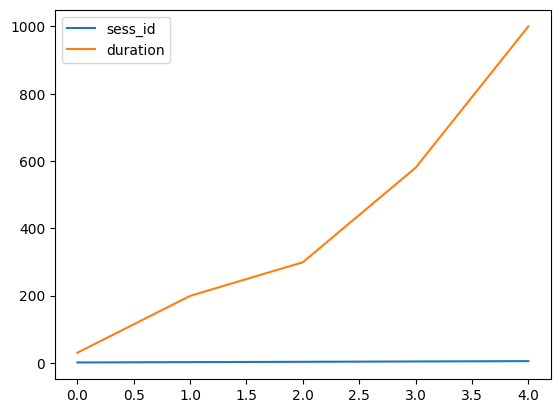

In [ ]:
query = '''SELECT sess_id, duration
            FROM sessions_duration
            '''

db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db.plot()

In [ ]:
query = '''SELECT
        AVG(duration) AS 'Avg',
        MAX(duration) AS 'Max',
        MIN(duration) AS 'Min'
        FROM sessions_duration
        '''
db = pd.read_sql_query(sql = sql_text(query), con = engine.connect())
db

,Avg,Max,Min
0,421.6,1000,30
